### Modules

In [1]:
%%capture

offline_packages = True # for packages not included in Kaggle env as of 14.03.2023
offline_huggingface = True

if offline_packages:
    !pip install faiss-gpu --no-index --find-links=file:///kaggle/input/faissgpu/
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
        --no-index --find-links=file:///kaggle/input/torch-geometric/
    pass
else:
    !pip install faiss-gpu torch-scatter torch-sparse \
        torch-cluster torch-spline-conv torch-geometric
        
if offline_huggingface:
    pre_trained_models_dir = r'/kaggle/input/lecr-models/lecr-models/'
else:
    pre_trained_models_dir = r'sentence-transformers/'
    
kaggle_dir = '/kaggle/'

main_module_path = kaggle_dir + 'input/lecr/'
import sys
import os
sys.path.insert(1, main_module_path + 'main.py')

%env TOKENIZERS_PARALLELISM=true

In [ ]:
from main import set_seed, setup_output, get_logger, prepare_data, \
    StagedTrainer, get_model, infer_stage_1, infer_stage_2, make_submission
from pathlib import Path
from transformers import AutoTokenizer, PreTrainedTokenizerFast
from dataclasses import dataclass, field
from typing import List
from datetime import datetime
import torch

### Config

In [4]:
# Config
@dataclass
class Config:
    # General
    seed: int =                               113 # seed for all random algorithms
    eps: float =                             1e-9 # clamp zeros to eps where infinities can arise
    device: str =                           "cuda" if torch.cuda.is_available() else "cpu"
    home_dir: str =                         Path(kaggle_dir)
    input_dir: str =                        home_dir/'input/learning-equality-curriculum-recommendations'
    output_dir: str =                       home_dir/'working/output'
    model_outputs_dir: str =                output_dir/'model_outputs'
    checkpoints_dir: str =                  output_dir/'checkpoints'
    tb_logs_dir: str =                      output_dir/'tb_logs'
    logs_dir: str =                         output_dir/'logs'
    encodings_dir: str =                    output_dir/'encodings'
    precision: int =                            5 # float precision for evaluation metrics
    
    # Model architecture
    encoder_backbone: str =                  pre_trained_models_dir + 'paraphrase-multilingual-MiniLM-L12-v2'
    neighborhood_sizes: List[int] =          field(default_factory=lambda: [6, 4, 2]) # stage 1 - no. neighboring topics to sample at each graph conv layer -- list length determines no. layers
    bypass_post: bool =                     False # stage 1 - bypass embedding post-processing block (graph convs / fc layers)
    freeze_backbone: bool =                  True # stage 1 - skip gradient calculation for all backbone parameters
    rerank_threshold: float =                0.55 # stage 2 - fixed threshold for binarizing classification scores
        
    # Topic/content features
    max_seq_length: int =                      96 # truncation length for tokenized text
    use_topic_title: bool =                  True # use 'title' field in topic representation
    use_topic_descr: bool =                  True # use 'description' field in topic representation
    use_topic_level: bool =                  True # etc.
    use_content_title: bool =                True
    use_content_descr: bool =                True
    use_content_text: bool =                 True
    field_sep_token: str =                    "#" # special token used in combining text fields
    tokenizer: PreTrainedTokenizerFast =   AutoTokenizer.from_pretrained(encoder_backbone, use_fast=True)
        
    # Training
    k_folds: int =                              4 # no. folds for GroupKFold cross-validation
    retriever_epochs: int =                     0 # no. training epochs for retriever (stage 1)
    reranker_epochs: int =                     10 # no. training epochs for reranker (stage 2)
    retriever_batch_size: int =               512 # no. topics in biencoder batch
    reranker_batch_size: int =                256 # no. pairs in cross encoder batch
    content_batch_size_ratio: int =             1 # no. contents per topic in batch (currently deprecated)
    reranker_neg_sample_ratio: int =          0.5 # no. negative samples per positive sample in reranker training set
    grad_accumulation_steps: int =              8 # no. batches to average before taking optimization step -- set to >1 to simulate larger batch size
    max_topics: int or bool =               False # max no. topics to load (for unit testing) -- set to False to disable sampling limit.
    val_size: int =                         False # no. samples in validation set (approx.) 
    max_grad_norm: float =                    1.0 # clip gradient norms -- set to 0 to disable clipping
    max_lr: float =                          5e-4 # max learning rate
    lr_decay_factor: float =                  0.5 # decay factor used by lr reducer
    lr_decay_patience: int =                    2 # no. epochs of no improvement for lr reducer step
    lr_pct_start: float =                     0.3 # pct of training steps used for increasing lr
    lr_div_factor: float =                     25 # lr at start of cycle = max_lr / div_factor
    lr_final_div_factor: float =              100 # lr at end of cycle = max_lr / final_div_factor
    train_only_fold: int =                     99 # dummy fold to assign to topics used only for training, e.g. those with 'category'=='source' (must be larger than 'k_folds')
    shuffle: bool =                          True # shuffle samples in dataloaders
    use_amp: bool =                          True # use automatic mixed precision (if GPU available)
    cast_dtype: torch.dtype =                torch.float16 if torch.cuda.is_available() else torch.bfloat16 # cast data type used with AMP
    gradient_checkpointing: bool =           True # use gradient checkpointing
        
    # Matching embeddings
    temperature: int =                       0.10 # cosine similarity scale in retriever loss function
    top_k: int =                               50 # max no. content recommendations at stage 1
    threshold_margin: float =                0.18 # size of margin for dynamic thresholding of similarity scores
    use_index_above: int =                    1e6 # size of content corpus above which to use ANN (i.e. FAISS index)
    index_nlinks: int =                        32 # no. neighbors in HNSW quantizer graph
    index_efConstruction: int =                64 # depth of HNSW exploration at construction time
    index_efSearch: int =                      32 # depth of HNSW exploration at search time
    index_nclusters: int =                   1024 # no. k-means clusters in IVF index
    index_nprobe: int =                       128 # no. IVF clusters to probe at search time
    
    def DEV_MODE(self):
        self.max_seq_length = 64
        self.max_topics = False
        self.topic_batch_size = 128
        self.content_batch_size_ratio = 1
        self.top_k = 20
        self.grad_accumulation_steps = 4
        self.retriever_epochs = 2
        self.reranker_epochs = 2
        self.k_folds = 2
        self.index_nlinks: int = 16
        self.index_efConstruction: int = 16
        self.index_efSearch: int = 8
        self.index_nclusters: int = 16
        self.index_nprobe: int = 16

if __name__ == '__main__':
    # Init config
    cfg = Config()
    set_seed()
    setup_output(
        clear_model_outputs=False,
        clear_checkpoints=False,
        clear_working=False,
    )
    
    # Monitoring
    profiler = False
    tensorboard = False
    if tensorboard:
        %reload_ext tensorboard
        %tensorboard --logdir cfg.tb_logs_dir
    
    # Quick overrides
#     cfg.DEV_MODE()

### Training

In [ ]:
training = True

if __name__ == '__main__' and training:
    START_TIME = datetime.now()
    logfile = f'train_log_{START_TIME.strftime("%Y-%m-%d_%H-%M-%S")}.log'
    logger = get_logger(cfg.logs_dir/logfile)
    logger.info(f'START TRAINING - {START_TIME}')
    
    # Pre-processing
    prepare_data(train=True)
    
    # K-fold validation
    for fold in range(cfg.k_folds):
        trainer = StagedTrainer(fold)
    
        for stage, n_epochs in trainer.stage_epochs.items():
            if n_epochs == 0: continue
                
            trainer.setup_stage(stage)
            model = get_model(stage)
#             ckpt = torch.load('/kaggle/input/lecr-models/checkpoints/fine-tuned-retriever-backbone-paraphrase-multilingual-MiniLM-L12-v2/retriever_ckpt_20230327_175920_20.pt')
#             trainer.load_checkpoint(model, ckpt)
            
            if profiler:
                %reload_ext line_profiler
                %lprun -f prepare_retriever_batch -f prepare_reranker_batch -f trainer.run_epoch -f trainer.make_eval_recos -f trainer.train trainer.train(model)
            else:
                trainer.train(model)

        best_model_str = ""\
        f"    epochs: {trainer.stage_epochs.values()}\n"\
        f"    retriever_val_loss: {trainer.best_model['retriever_val_loss']:.5f}\n"\
        f"    retriever_ckpt_path: {trainer.best_model['retriever_ckpt_path']}\n"\
        f"    reranker_val_loss: {trainer.best_model['reranker_val_loss']:.5f}\n"\
        f"    reranker_ckpt_path: {trainer.best_model['reranker_ckpt_path']}"
        logger.info(f"################ Fold {fold} best performance: ################\n{best_model_str}")
        break # one fold only
        
    logger.info('Checkpoints stored:\n' + '\n'.join(['    ' + p
                for p in sorted(os.listdir(cfg.checkpoints_dir))]))

    END_TIME = datetime.now()
    logger.info(f'END TRAINING   - {END_TIME} (+{END_TIME - START_TIME})')

In [ ]:
# del model, trainer
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# !zip -r checkpoints.zip '/kaggle/working/output/checkpoints/retriever_ckpt_20230327_170217_4.pt'

- 20 epochs 'paraphrase-multilingual-MiniLM-L12-v2' backbone fine-tuning

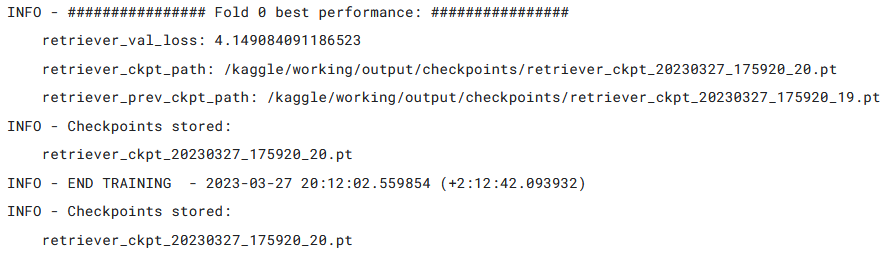

### Inference

In [ ]:
inference  = False

stage_1    = True
stage_2    = True

submission = False

if __name__ == '__main__' and inference:
    assert stage_1 or stage_2, "Choose at least one stage to run"
    
    START_TIME = datetime.now()
    logfile = f'test_log_{START_TIME.strftime("%Y-%m-%d_%H-%M-%S")}.log'
    logger = get_logger(cfg.logs_dir/logfile)
    logger.info(f'START INFERENCE - {START_TIME}')
    
    # Pre-processing
    prepare_data(train=False)
    retriever_ckpt = torch.load(cfg.checkpoints_dir/'retriever_ckpt_20230327_163138_1.pt')
    reranker_ckpt = torch.load(cfg.checkpoints_dir/'reranker_ckpt_20230323_173614_1.pt')

    # Stage 1
    if stage_1:
        stage_1_pairs = infer_stage_1(retriever_ckpt)
        logger.info(f'STAGE 1 COMPLETE')

    # Stage 2
    if stage_2:
        stage_2_pairs = infer_stage_2(reranker_ckpt, stage_1_pairs)    
        logger.info(f'STAGE 2 COMPLETE')

    # Output submission
    if submission:
        pairs = stage_2_pairs if stage_2 else stage_1_pairs
        make_submission(pairs)

    END_TIME = datetime.now()
    logger.info(f'END INFERENCE   - {END_TIME} (+{END_TIME - START_TIME})')

- all-MiniLM-L6-v2 (5 epochs fine-tuning)

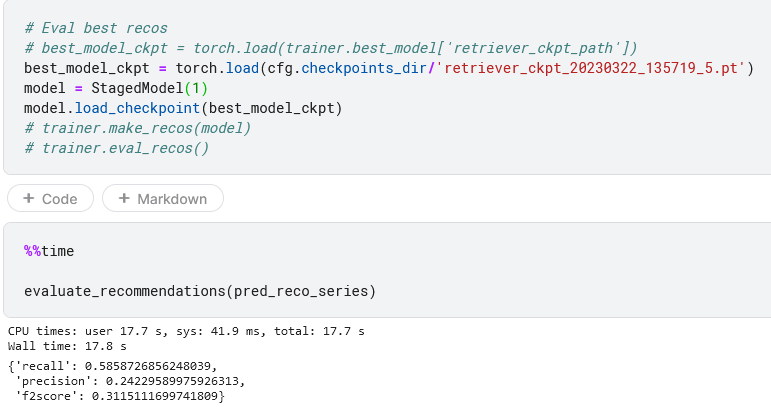

- paraphrase-multilingual-MiniLM-L12-v2 (1 epoch fine-tuning)

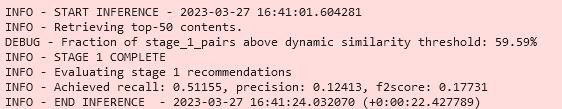

- paraphrase-multilingual-MiniLM-L12-v2 (no fine-tuning)

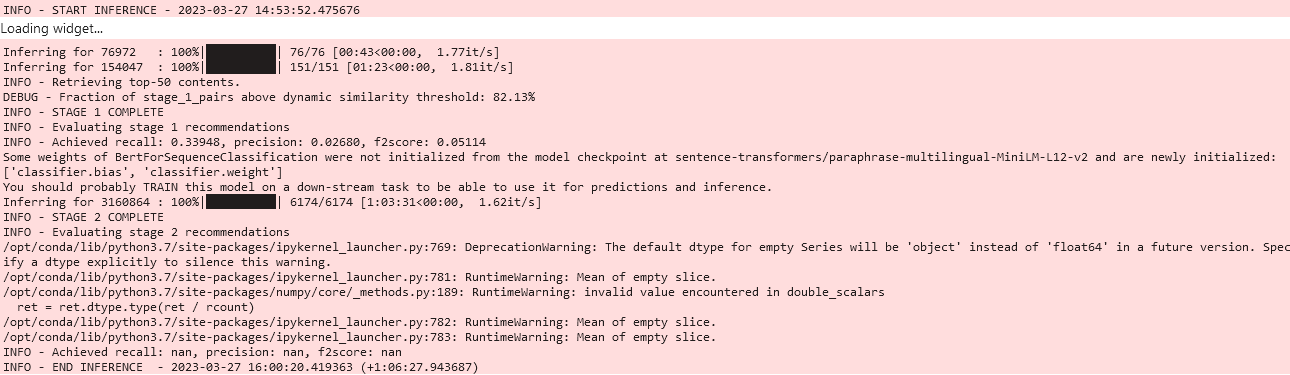

### Experiments

In [ ]:
# model_name = 'paraphrase-multilingual-MiniLM-L12-v2'
# load_path = Path('sentence-transformers')/model_name
# save_path = Path('lecr-models')/model_name
# save_path.mkdir(parents=True, exist_ok=True)

# model = AutoModel.from_pretrained(load_path)
# tokenizer = AutoTokenizer.from_pretrained(load_path, use_fast=True)
# model.save_pretrained(save_path)
# tokenizer.save_pretrained(save_path)

In [ ]:
# !zip -r lecr-models.zip '/kaggle/working/lecr-models'

In [ ]:
# torch.cuda.max_memory_allocated() / 1024**2, torch.cuda.memory_allocated() / 1024**2

In [ ]:
# # Test
# num_topics = 512
# topic_nums = torch.randperm(len(trainer.train_ids))[:num_topics]
# batch = prepare_retriever_batch(topic_nums)

In [ ]:
# with torch.autocast(device_type=cfg.device, dtype=cfg.cast_dtype) and torch.no_grad():
#     topic_emb = model.model.topic_encoder(*batch['inputs'][:2])['topic_emb']
#     content_emb = model.model.content_encoder(batch['inputs'][2])['content_emb']
    
# rand_topic_emb = torch.nn.functional.normalize(torch.randn((num_topics, 384), dtype=torch.float)).to('cuda')
# rand_content_emb = torch.nn.functional.normalize(torch.randn((len(content_emb), 384), dtype=torch.float)).to('cuda')

# labels = batch['labels'][batch['labels'].sum(1) > 0]
# labels.size(), labels.sum().item()

In [ ]:
# %%time

# av_nll_model_emb = similarity_nll(topic_emb[:num_topics][batch['labels'].sum(1) > 0], content_emb, labels)
# av_nll_model_emb

In [ ]:
# av_nll_rand_emb = similarity_nll(rand_topic_emb[:num_topics][batch['labels'].sum(1) > 0], content_emb, labels)
# av_nll_rand_emb

In [ ]:
# av_nll_rand_rand_emb = similarity_nll(rand_topic_emb[:num_topics][batch['labels'].sum(1) > 0], rand_content_emb[:labels.size(1)], labels)
# av_nll_rand_rand_emb

In [ ]:
# %%time

# idx_mask = (((sup_edge_index.T.unsqueeze(1) - sub_edge_index.T).sum(-1) == 0).sum(-1) == 0)
# missing_gt_pairs = sup_edge_index.T[idx_mask]

In [ ]:
# cfg.temperature = 0.1
# cfg.eps = 1e-9

# def similarity_nll(topic_emb, content_emb, labels):
#     T, C, D = (topic_emb.size()[0], *content_emb.size())
#     assert topic_emb.size()[1] == D, "Topic and content embedding dimensionalities do not match"
#     sim = topic_emb @ content_emb.T
#     exp_sim = torch.exp(sim / cfg.temperature)
# #     logger.debug([exp_sim.min().item(), exp_sim.max().item(), exp_sim.mean().item()])
#     likelihood = ((exp_sim * labels).sum(1) / exp_sim.sum(1)).clamp(cfg.eps)
# #     logger.debug([likelihood.min().item(), likelihood.max().item(), likelihood.mean().item()])
#     return -torch.log(likelihood).mean()

# def sim_nll(topic_emb, content_emb, labels):
#     T, C, D = (topic_emb.size()[0], *content_emb.size())
#     assert topic_emb.size()[1] == D, "Topic and content embedding dimensionalities do not match"
#     sim = topic_emb @ content_emb.T / cfg.temperature
# #     if torch.equal(labels, torch.eye(labels.size(0), device=labels.device)):
# #         labels = torch.arange(labels.size(0), device=labels.device)
#     return nn.CrossEntropyLoss()(sim, labels)

In [ ]:
# import torch
# batch_size = 512
# topic_emb = torch.nn.functional.normalize(torch.randn((len(topics_df), 384), dtype=torch.float)).to('cuda')
# content_emb = torch.nn.functional.normalize(torch.randn((len(content_df), 384), dtype=torch.float)).to('cuda')
# rand_topic_nums = torch.randperm(len(topics_df))[:batch_size]
# batch = prepare_retriever_batch(rand_topic_nums)
# rand_content_nums = torch.randperm(len(content_df))[:batch['inputs'][2]['input_ids'].shape[0]]
# loss = similarity_nll(topic_emb[rand_topic_nums], content_emb[rand_content_nums], batch['labels'])
# loss.item()

In [ ]:
# def similarity_nll(topic_emb, content_emb, labels):
#     T, C, D = (topic_emb.size()[0], *content_emb.size())
#     assert topic_emb.size()[1] == D, "Topic and content embedding dimensionalities do not match"
#     sim = topic_emb @ content_emb.T
#     exp_sim = torch.exp(sim / cfg.temperature)
#     logger.debug([exp_sim.min().item(), exp_sim.max().item(), exp_sim.mean().item()])
#     likelihood = ((exp_sim * labels).sum(1) / exp_sim.sum(1)).clamp(cfg.eps)
#     logger.debug([likelihood.min().item(), likelihood.max().item(), likelihood.mean().item()])
#     return -torch.log(likelihood).mean()

In [ ]:
# %%time

# top_k_content_matrix = retrieve_top_k_contents(rand_topic_emb, rand_content_emb)
# pairs = get_pairs(top_k_content_matrix)
# recos = reco_pairs_to_series(pairs)
# eval_metrics = evaluate_recommendations(recos)
# print(f'Achieved ' + ', '.join([f'{k}: {v:.6f}' for k, v in eval_metrics.items()]))

# Random normal topic_emb and content_emb achieve @100 recall: 0.200985, precision: 0.000019, f2score: 0.000059